In [1]:

import numpy as np

import scoobpsf
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import *
import scoobpsf.compact_scoob as cscoob
import scoobpsf.dm as dm
import scoobpsf.scoobi as scoobi

import time 
from importlib import reload

import lina

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle


Jax available; Jax model can be used.
Succesfully initialized testbed interface.


In [47]:
reload(scoobi)
tbi = scoobi.SCOOBI(cam_channel='scicam', dm_channel='dm00disp05')
# tbi.zero_dm()

Succesfully initialized testbed interface.


In [9]:
scoobi.move_psf(60, 0)

In [13]:
tbi.bias = 63

In [48]:
tbi.exp_time = 0.005*u.s
tbi.Nframes = 100

In [49]:
tbi.attenuation = 30

In [50]:
tbi.normalize = True
# tbi.normalize = False

INFO:utils:Got semaphore index 1.


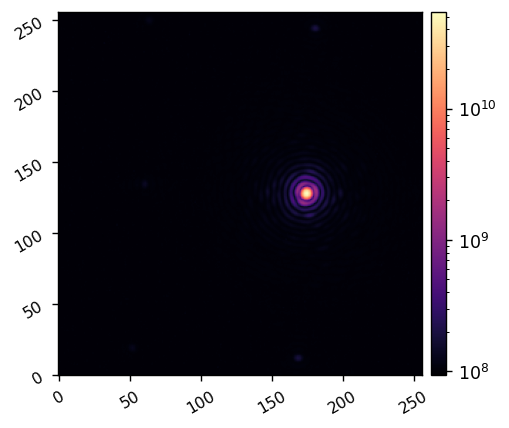

In [51]:
raw_im = tbi.snap()
imshow1(raw_im, lognorm=True,)

In [52]:
tbi.Imax_ref = xp.max(raw_im)
tbi.att_ref = tbi.attenuation

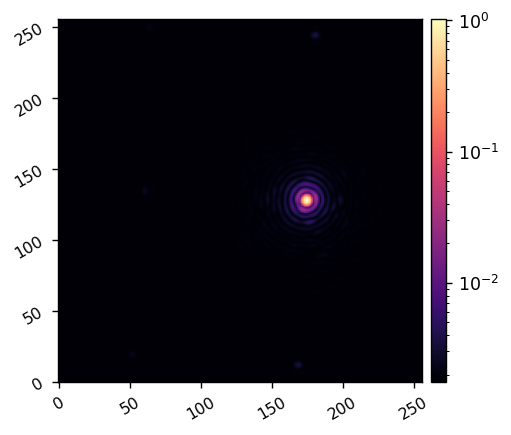

In [53]:
ref_psf = tbi.snap()
imshow1(ref_psf, lognorm=True)

In [54]:
scoobi.move_psf(-60,0)

In [93]:
scoobi.move_psf(-1,0)

In [95]:
scoobi.move_psf(0,-1)

In [148]:
tbi.exp_time = 50*u.millisecond

In [150]:
tbi.attenuation = 2

In [74]:
tbi.Nframes = 10

In [176]:
tbi.npsf = 128
tbi.x_shift = -5
tbi.y_shift = -4

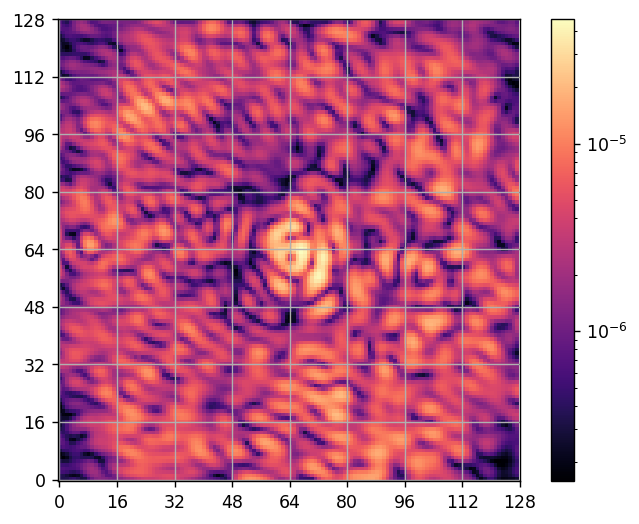

In [197]:
ref_im = tbi.snap()

nticks = 8
ticks = np.arange(0, tbi.npsf+1, tbi.npsf//nticks)
plt.figure(dpi=125)
plt.imshow(ensure_np_array(ref_im), norm=LogNorm(), cmap='magma')
plt.colorbar()
plt.xticks(ticks)
plt.yticks(ticks)
plt.grid()



In [178]:
tbi.reset_dm()

array(4.48496843e-06)

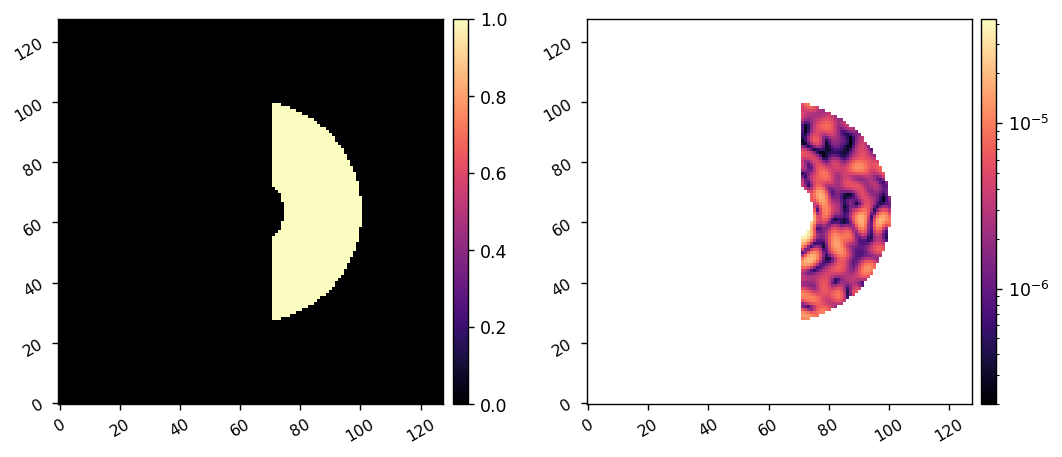

In [199]:
control_mask = lina.utils.create_annular_focal_plane_mask(tbi, 3, 10, 2)
display(xp.mean(ref_im[control_mask]))
imshow2(control_mask, ref_im*control_mask, lognorm2=True)

In [200]:
pixelscale_lamD = 32/(128-10)
print(pixelscale_lamD)

0.2711864406779661


In [182]:
tbi.psf_pixelscale_lamD = pixelscale_lamD

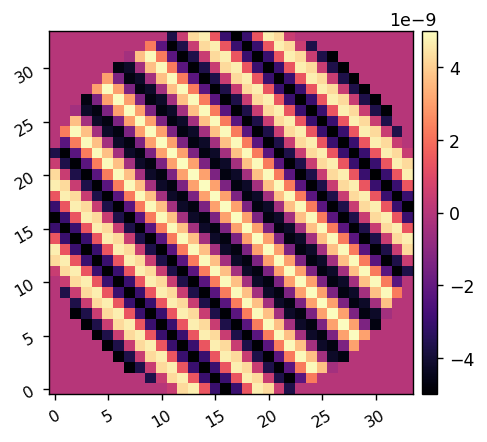

In [201]:
Nact = 34
xpp = np.arange(-Nact//2, Nact//2) + 1/2
ppx, ppy = np.meshgrid(xpp,xpp)
amp = 5e-9
separation = 5
command = amp*np.cos(2*np.pi*(ppx + ppy)*separation/Nact)*tbi.dm_mask

imshow1(command)
tbi.set_dm(ensure_np_array(command))

In [202]:
tbi.reset_dm()

In [110]:
xp.array

<function cupy._creation.from_data.array(obj, dtype=None, copy=True, order='K', subok=False, ndmin=0)>

In [203]:
from astropy.io import fits

date = 20240304
response_matrix = xp.array(fits.getdata(f'jacobian_{date}.fits'))

In [195]:
tbi.Nframes = 10

In [196]:
tbi.dm_delay = 0.1

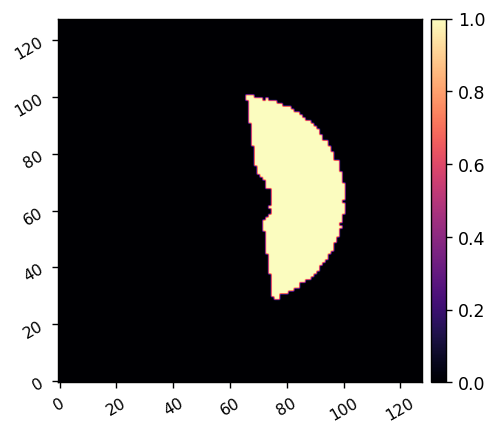

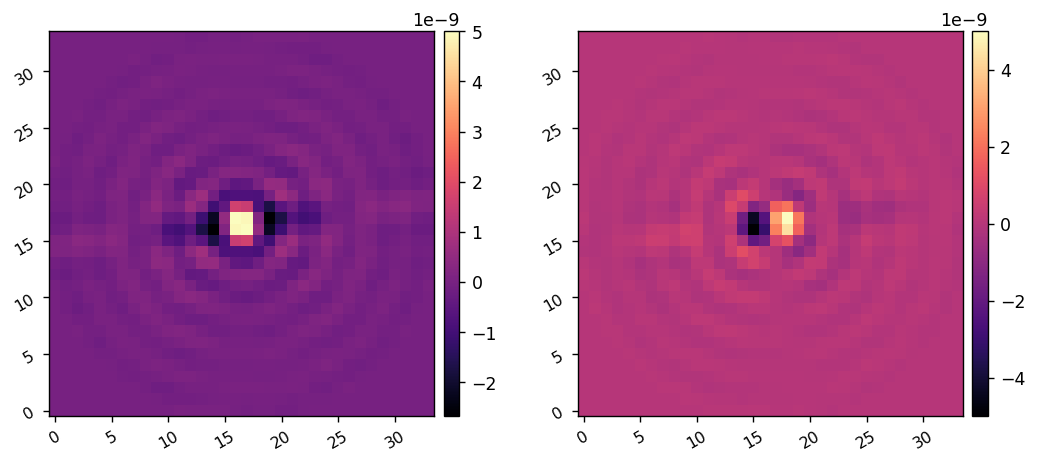

In [205]:
probe_amp = 5e-9
probe_control_mask = lina.utils.create_annular_focal_plane_mask(tbi, 3, 10, 2, rotation=-7.5, plot=True)
probe_modes = lina.utils.create_fourier_probes(tbi, probe_control_mask, fourier_sampling=0.25, nprobes=2)
probes = probe_amp*probe_modes

imshow2(probes[0], probes[1])

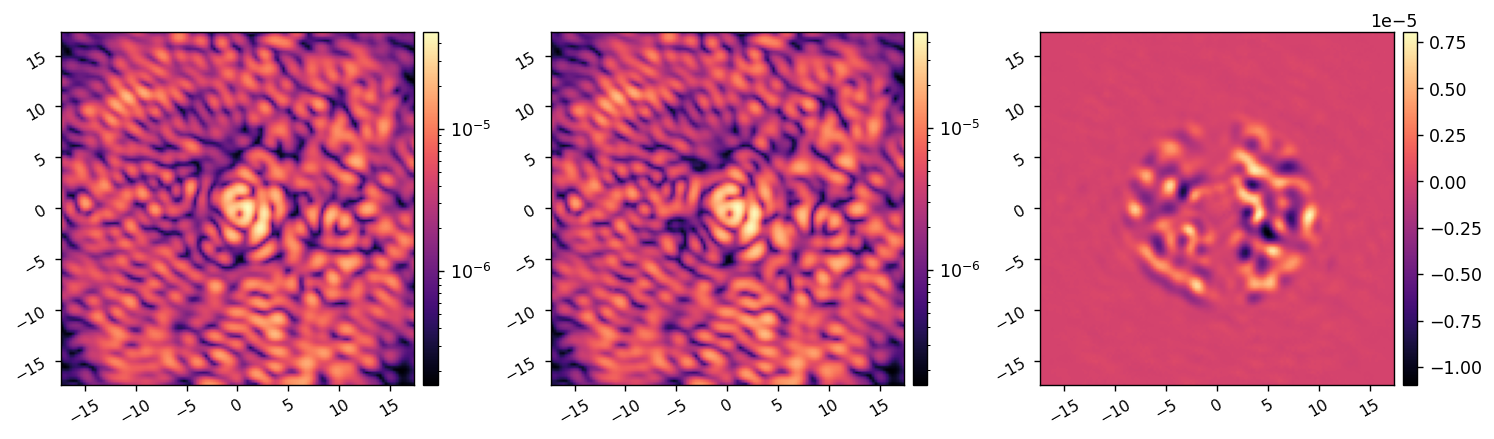

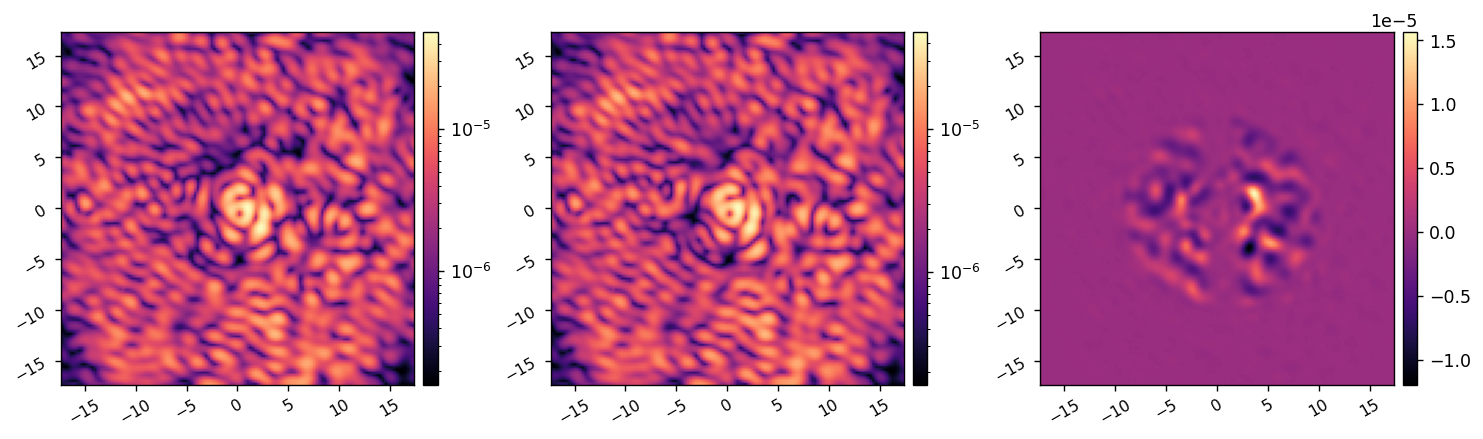

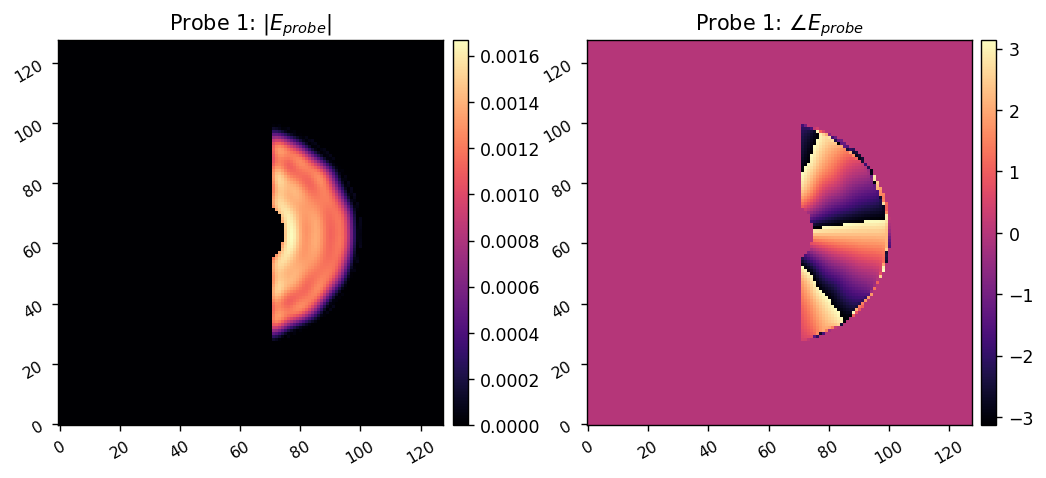

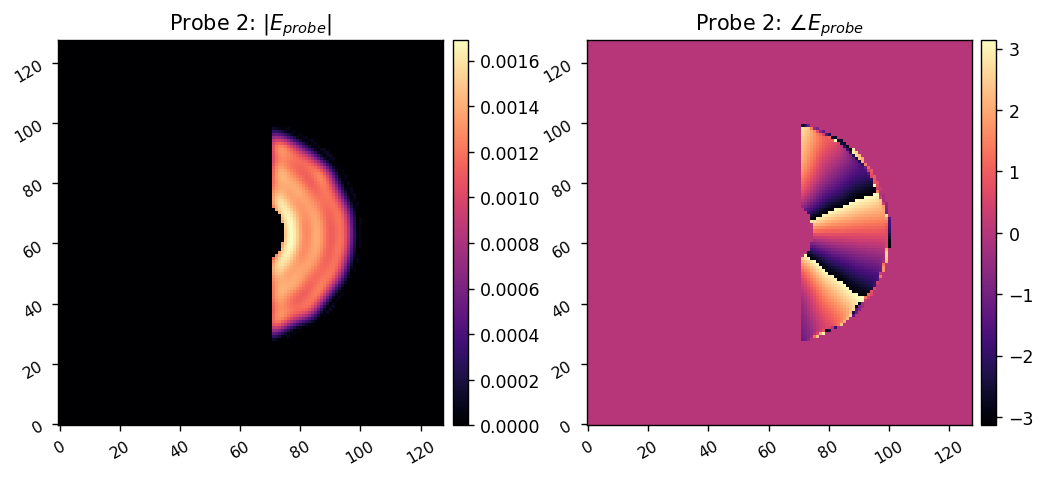

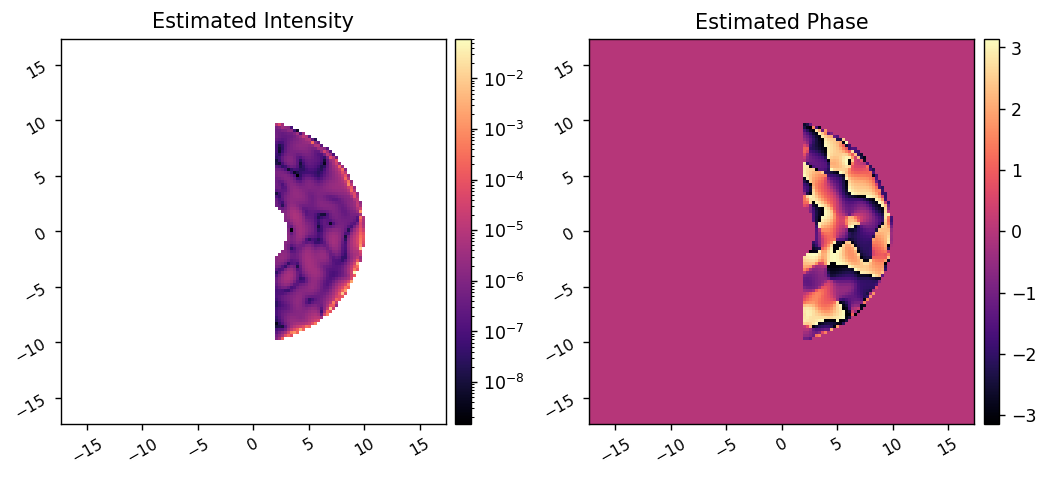

In [206]:
est0 = lina.pwp.run_pwp_bp(tbi, control_mask, probes, use='J', jacobian=response_matrix, plot=True)

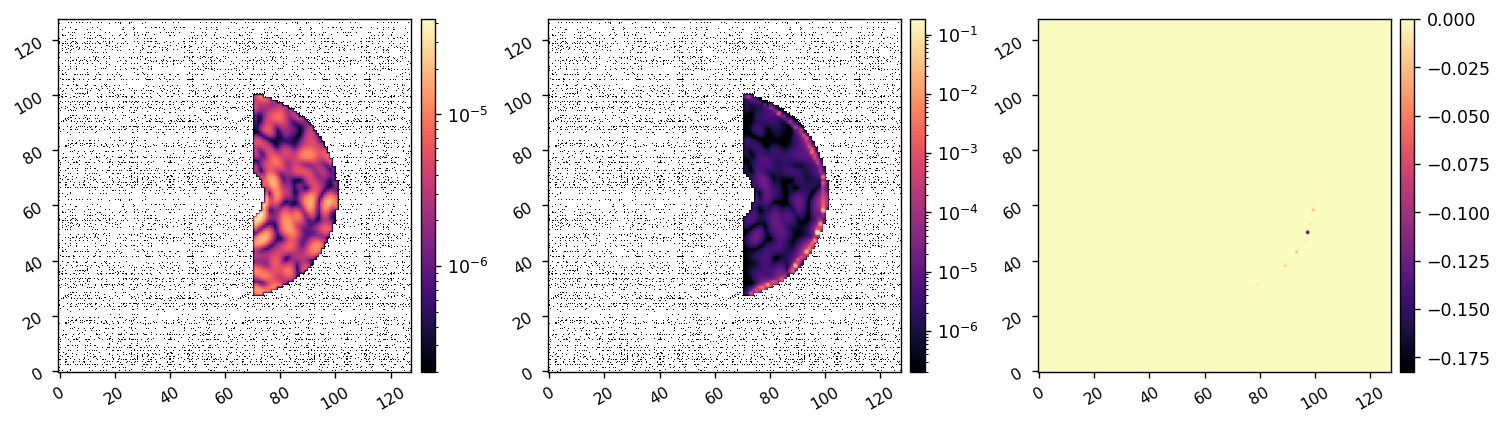

array(-0.00021245)

In [207]:
Iest =  3*xp.abs(est0)**2

diff = ref_im*control_mask-Iest

imshow3(ref_im*control_mask, Iest, diff, 
        lognorm1=True, lognorm2=True, 
        vmin2=xp.min(ref_im[control_mask]))

xp.mean(diff[control_mask])

# Run EFC + PWP

In [208]:
poke_modes = lina.utils.create_all_poke_modes(tbi.dm_mask)

In [211]:
tbi.reset_dm()

images = xp.array([ref_im])
estimates = xp.array([est0])
dm_commands = xp.array([tbi.get_dm()])

In [67]:
type(tbi.get_dm())

numpy.ndarray

Beginning closed-loop EFC.
	Running iteration 1/2.
Using run_pwp_bp to estimate electric field


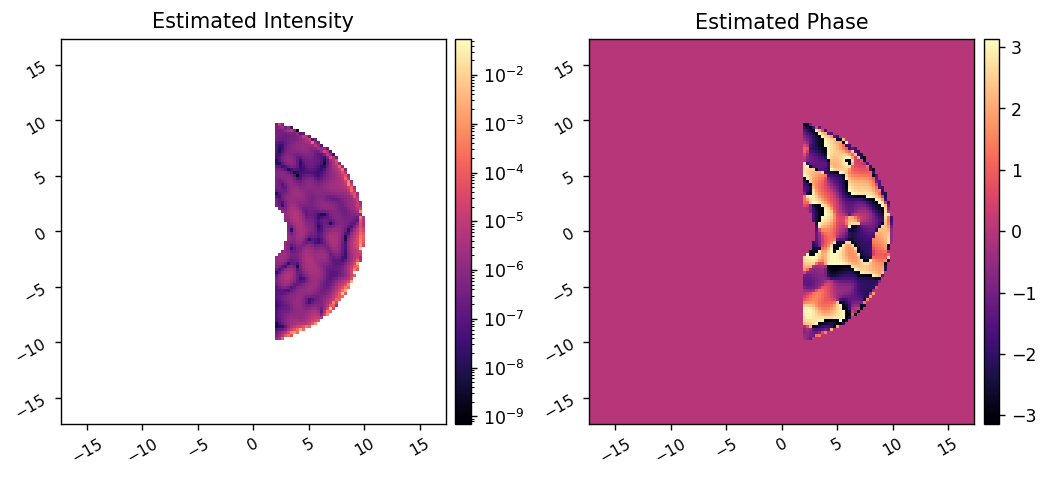

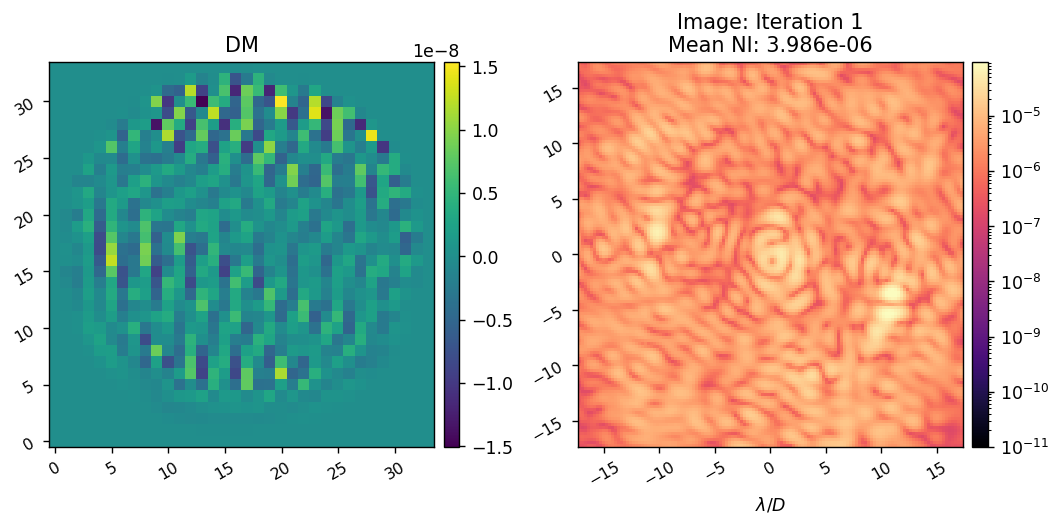

	Running iteration 2/2.
Using run_pwp_bp to estimate electric field


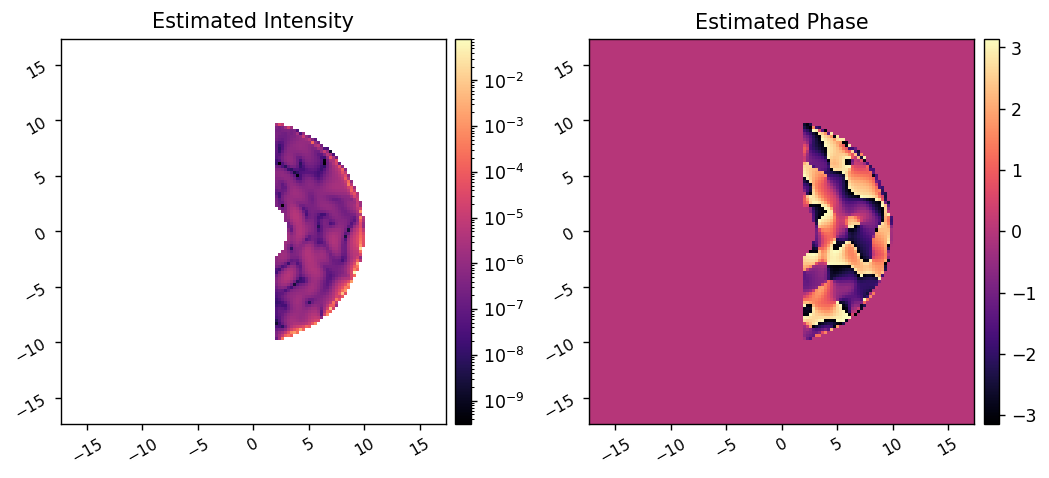

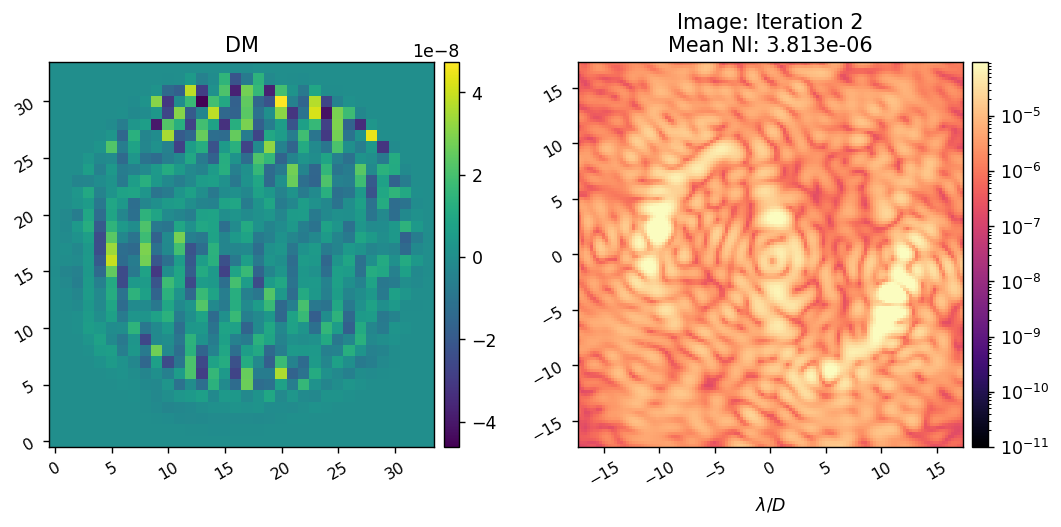

EFC completed in 13.055 sec.


In [210]:
reload(lina.efc)

pwp_fun = lina.pwp.run_pwp_bp
probe_amp = 5e-9
pwp_params = {
    'probes':probe_amp*probe_modes,
    'control_mask':control_mask,
    'use':'J',
    'jacobian':response_matrix,
    'plot_est':True,
}

condition = -2
# condition = -4
control_matrix = lina.utils.beta_reg(response_matrix, condition)

images, estimates, dm_commands = lina.efc.run(tbi, 
                                              poke_modes,
                                              control_matrix,
                                              control_mask, 
                                              est_fun=pwp_fun,
                                              est_params=pwp_params,
                                              loop_gain=0.5, 
                                              leakage=0.0,
                                              iterations=2,
                                              plot_all=True,
                                              plot_current=True,
                                              plot_sms=False,
                                              plot_radial_contrast=False,
                                              old_images=images,
                                              old_fields=estimates,
                                              old_commands=dm_commands,
                                             )